<a href="https://colab.research.google.com/github/VTNay/MEC557-Project/blob/Zhichuan-MA/MEC557_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Project: Weather station

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/map.png?raw=1" width=400>

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris

### Data set

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/annual_temperature.png?raw=1" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

In [17]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from functools import reduce
from matplotlib import pyplot as plt
from sklearn import preprocessing

paris_path = Path('/content/drive/My Drive/PHY557_Project/weather/paris')
brest_path = Path('/content/drive/My Drive/PHY557_Project/weather/brest')
london_path = Path('/content/drive/My Drive/PHY557_Project/weather/london')
marseille_path = Path('/content/drive/My Drive/PHY557_Project/weather/marseille')
berlin_path = Path('/content/drive/My Drive/PHY557_Project/weather/berlin')

file_path = {'t2m': 't2m.nc', 'blh': 'blh.nc', 'd2m': 'd2m.nc', 'skt': 'skt.nc', 'sp': 'sp.nc', 'ssrd': 'ssrd.nc', 'tcc': 'tcc.nc', 'tp': 'tp.nc', 'u10': 'u10.nc', 'v10': 'v10.nc'}
City_path = {'Paris': paris_path, 'Brest': brest_path, 'London': london_path, 'Marseille': marseille_path, 'Berlin': berlin_path}

Weather_stations = {'Paris': [], 'Brest': [], 'London': [], 'Marseille': [], 'Berlin': []}
for i in Weather_stations:
  Weather_stations[i] = {'t2m': [], 'blh': [], 'd2m': [], 'skt': [], 'sp': [], 'ssrd': [], 'tcc': [], 'tp': [], 'u10': [], 'v10': []}

for city in Weather_stations:
  for i in Weather_stations[city]:
    temp = xr.open_dataset(Path(City_path[city], file_path[i]))
    temp = temp.to_dataframe()
    if i == 'd2m' or i == 'blh':
      temp = temp.droplevel([1,2])
    else:
      temp = temp.droplevel([0,1])
    Weather_stations[city][i] = temp
  #merge them into 1 dataframe
  Weather_stations[city] = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), Weather_stations[city].values())

In [3]:
Berlin = Weather_stations['Berlin']
Brest =  Weather_stations['Brest']
London = Weather_stations['London']
Paris = Weather_stations['Paris']
Marseille = Weather_stations['Marseille']
Paris = Paris[Paris.index < '2020-01-01 07:00:00'] #All dataframe has the same number of rows

In [4]:
# Function to rename columns
def rename_columns(df, prefix):
    return df.rename(columns={col: f"{prefix}_{col}" for col in df.columns})
# Rename columns of each DataFrame so that the feature in X will be 'Berlin_t2m', 'Berlin_u10', 'London_t2m',...
Berlin = rename_columns(Berlin, 'Berlin')
Brest = rename_columns(Brest, 'Brest')
London = rename_columns(London, 'London')
Marseille = rename_columns(Marseille, 'Marseille')

In [8]:
#Data cleaning
# Concatenate X = Berlin, Brest, London, Marseille and y = Paris
combined = pd.concat([Berlin, Brest, London, Marseille, Paris], axis=1)
# Drop NA values
combined = combined.dropna()
# Split them back into X and y
X = combined.iloc[:, :-10]  # X has 40 features
y = combined.loc[:,'t2m']  # y is the temperature in Paris

In [9]:
#Linear Regression for Paris_t2m with 40 features - the most naive approach
# Import scikit-learn cross-validation function
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept= True)
n_splits = 30
R2_cv = cross_val_score(reg, X, y, cv=n_splits)
print(R2_cv.mean())

0.9137192694903422


In [15]:
y

time
1980-01-01 07:00:00    272.039154
1980-01-01 08:00:00    272.022308
1980-01-01 09:00:00    271.751892
1980-01-01 10:00:00    274.506470
1980-01-01 11:00:00    275.079346
                          ...    
2019-12-31 19:00:00    272.958130
2019-12-31 20:00:00    272.240845
2019-12-31 21:00:00    271.729919
2019-12-31 22:00:00    273.190796
2019-12-31 23:00:00    272.771423
Name: t2m, Length: 350633, dtype: float32

In [22]:
#Ridge regression
# Import Ridge
from sklearn.linear_model import Ridge
# Call the Ridge regressor
reg_class = Ridge

# Number of years
n_years = y.index.year.max() - y.index.year.min() + 1
# Number of test months
N_TEST_YEARS = 4
n_test = 365 * N_TEST_YEARS # 365 days per year

# Define array of regularization-parameter values
complexity_rng = np.logspace(0, 7, 35)

# Select cross validation data
X_cv = X[:-n_test]
y_cv = y[:-n_test]

# Select test set for later
X_test = X[-n_test:]
y_test = y[-n_test:]

# Set number of splits for cross-validation
n_splits_cv = n_years - n_test // 365

# Declare empty arrays in which to store r2 scores and coefficients
r2_validation = np.empty(complexity_rng.shape)
coefs = np.empty((len(complexity_rng), X.shape[1]))

# Loop over regularization-parameter values
for k, complexity in enumerate(complexity_rng):
    # Define the Ridge estimator for particular regularization-parameter value
    reg = reg_class(alpha=complexity)

    # Get r2 test scores from k-fold cross-validation
    r2_validation_arr = cross_val_score(reg, X_cv, y_cv, cv=n_splits_cv)

    # Get r2 expected prediction score by averaging over test scores
    r2_validation[k] = r2_validation_arr.mean()

    # Save coefficients
    reg.fit(X_cv, y_cv)
    coefs[k] = reg.coef_

# Get the best values of the regularization parameter, prediction R2 and coefficients
i_best = np.argmax(r2_validation)
complexity_best = complexity_rng[i_best]
r2_best = r2_validation[i_best]
coefs_best = coefs[i_best]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11487e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11478e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11833e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11857e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

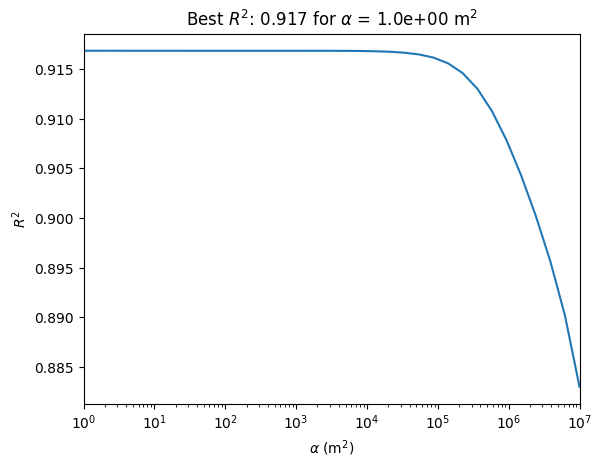

In [23]:
# Plot validation curve
complexity_label = r'$\alpha$ (m$^2$)'
plt.figure()
plt.plot(complexity_rng, r2_validation)
plt.xscale('log')
plt.xlabel(complexity_label)
plt.ylabel(r'$R^2$')
_ = plt.title(r'Best $R^2$: {:.3} for $\alpha$ = {:.1e} m$^2$'.format(
    r2_best, complexity_best))
_ = plt.xlim(complexity_rng[[0, -1]])

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_lmd.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo IPSL" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ipsl.png?raw=1" style="display: inline-block"/>

<img alt="Logo E4C" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_e4c_final.png?raw=1" style="display: inline-block"/>

<img alt="Logo EP" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ep.png?raw=1" style="display: inline-block"/>

<img alt="Logo SU" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_su.png?raw=1" style="display: inline-block"/>

<img alt="Logo ENS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ens.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo CNRS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_cnrs.png?raw=1" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>